# Programming Assignment 4

Celio Bueri, Christoph Stelz

## Exercise question

In the second example, the data are not linearly separable.

## Boilerplate code

In [267]:
import numpy as np
from sklearn.base import BaseEstimator

class LinearClassifier(BaseEstimator):
    """
    General class for binary linear classifiers. Implements the predict
    function, which is the same for all binary linear classifiers. There are
    also two utility functions.
    """

    def decision_function(self, X):
        """
        Computes the decision function for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """
        return X.dot(self.w)

    def predict(self, X):
        """
        Predicts the outputs for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """

        # First compute the output scores
        scores = self.decision_function(X)

        # Select the positive or negative class label, depending on whether
        # the score was positive or negative.
        out = np.select([scores >= 0.0, scores < 0.0],
                        [self.positive_class,
                         self.negative_class])
        return out

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of
        classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])


## SVC Implementation

In [268]:
class SVCImpl(LinearClassifier):
    def __init__(self, n_iter=1000, regularizer=0.001, print_epoch_stats=True):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # pick random indexes for each iteration
        indices = np.random.randint(X.shape[0], size=self.n_iter)

        # initialise the number of iteration
        t = 0

        for i in indices:
            t += 1
            # update the learning rate
            lr = 1.0 / (self.regularizer * t)

            x, y = X[i], Ye[i]

            # Compute the output score for this instance.
            score = x.dot(self.w)

            # update the weights
            if y * score < 1:
                self.w = (1 - self.regularizer * lr) * self.w + lr * y * x
            else:
                self.w = (1 - self.regularizer * lr) * self.w

            # print every 100 iterations
            if self.print_epoch_stats and t % 100 == 0:
                print(f'iteration : {t}, train_loss : { - self.score(X, Y)}')

    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return -(self.regularizer / 2 * min_weight + loss / X.shape[0])

## Logistic Regression Implementation

In [269]:
class LogisticRegressionImpl(LinearClassifier):
    def __init__(self, n_iter=1000, regularizer=0.001, print_epoch_stats=True):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

       # pick random indexes for each iteration
        indices = np.random.randint(X.shape[0], size=self.n_iter)

        # initialise the number of iteration
        t = 0

        for i in indices:
            t += 1
            # update the learning rate
            lr = 1.0 / (self.regularizer * t)

            x, y = X[i], Ye[i]

            # Compute the output score for this instance.
            score = x.dot(self.w)

            # update the weights
            if y * score < 1:
                self.w = (1 - self.regularizer * lr) * self.w + lr * x * y / (1 + np.exp(y*score))
            else:
                self.w = (1 - self.regularizer * lr) * self.w

            # print every 100 iterations
            if self.print_epoch_stats and t % 100 == 0:
                print(f'iteration : {t}, train_loss : { - self.score(X, Y)}')

    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for logistic regression
            loss += np.log(1 + np.exp(-y * x.dot(self.w)))
        return -(self.regularizer / 2 * min_weight + loss / X.shape[0])

## Preparing training data

In [270]:

import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y


# Read all the documents.
X, Y = read_data('data/all_sentiment_shuffled.txt')

# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)


## Testing our classifiers 	

In [271]:

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    SVCImpl(n_iter=10000, regularizer=0.0001)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

iteration : 100, train_loss : 23.7500901400999
iteration : 200, train_loss : 10.35161614333661
iteration : 300, train_loss : 6.282353450834151
iteration : 400, train_loss : 4.643914602593124
iteration : 500, train_loss : 3.7376008689449387
iteration : 600, train_loss : 3.0790032622289316
iteration : 700, train_loss : 2.6288736308419764
iteration : 800, train_loss : 2.3461505790043704
iteration : 900, train_loss : 2.090620285691015
iteration : 1000, train_loss : 2.143810997129464
iteration : 1100, train_loss : 1.8283827745517633
iteration : 1200, train_loss : 1.6750045692332953
iteration : 1300, train_loss : 1.5602801599243854
iteration : 1400, train_loss : 1.4328170149479367
iteration : 1500, train_loss : 1.3204937776901113
iteration : 1600, train_loss : 1.237390641348171
iteration : 1700, train_loss : 1.4611643209183096
iteration : 1800, train_loss : 1.5929343320402545
iteration : 1900, train_loss : 1.0559429107252298
iteration : 2000, train_loss : 1.0379414856660045
iteration : 2100,

In [272]:

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    LogisticRegressionImpl(n_iter=10000, regularizer=0.0001)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

iteration : 100, train_loss : 23.606718607669603
iteration : 200, train_loss : 9.348465207494986
iteration : 300, train_loss : 5.251044064534685
iteration : 400, train_loss : 3.5134494604180837
iteration : 500, train_loss : 2.8933426378757474
iteration : 600, train_loss : 2.35824765003992
iteration : 700, train_loss : 2.233111749533012
iteration : 800, train_loss : 1.7019273786512907
iteration : 900, train_loss : 1.536981202057833
iteration : 1000, train_loss : 1.528208786866879
iteration : 1100, train_loss : 1.2237996601134773
iteration : 1200, train_loss : 1.172943697660891
iteration : 1300, train_loss : 1.0348530123254376
iteration : 1400, train_loss : 0.9702088284902379
iteration : 1500, train_loss : 1.0299184915737136
iteration : 1600, train_loss : 0.8372265766871312
iteration : 1700, train_loss : 0.9127504500794765
iteration : 1800, train_loss : 0.8757333143706965
iteration : 1900, train_loss : 0.7474620209967601
iteration : 2000, train_loss : 0.7238424370453336
iteration : 2100,

In [273]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = {
    'classifier__n_iter': [10000, 30000, 100000, 1000000],
    'classifier__regularizer': [0.01, 0.001, 0.0001, 0.00001]
}


pipeline = Pipeline(steps=[
    ("vect",TfidfVectorizer()),
    ("select", SelectKBest(k=1000)),
    ("norm", Normalizer()),
    ("classifier", SVCImpl(print_epoch_stats=False))
])

grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, return_train_score=True)

grid_search.fit(X, Y)

print("Best parameter (loss=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Yguess = grid_search.best_estimator_.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Best parameter (loss=-0.424):
{'classifier__n_iter': 1000000, 'classifier__regularizer': 1e-05}
Accuracy: 0.8976.


## Optimizing Performance

### a) BLAS operations

In this version we replaced the Numpy operations with BLAS functions from scipy.
One pitfall we encountered is that with inplace operations like `daxpy`, the argument ordering matters a lot.

In [274]:
from scipy.linalg.blas import ddot, dscal, daxpy

class SVCImplBLAS(LinearClassifier):
    def __init__(self, n_iter=20, lr=0.01, regularizer=0.0, print_epoch_stats=True):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lr = lr
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # training algorithm:
        for i in range(self.n_iter):
            for x, y in zip(X, Ye):

                # Compute the output score for this instance.
                score = ddot(self.w, x)
                
                dscal(1 - self.regularizer * self.lr, self.w)
                if y * score < 1:
                    daxpy(x, self.w, a=(self.lr * y))
                
            if self.print_epoch_stats:
                print(f'epoch : {i}, train_loss : {self.score(X, Y)}')

    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(ddot(self.w, self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return self.regularizer / 2 * min_weight + loss / X.shape[0]

### b) Sparse Vectors

In [275]:

class SVCImplSparse(LinearClassifier):

    def __init__(self, n_iter=1000, regularizer=0.001, print_epoch_stats=True):
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def fit(self, X, Y):
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.

        indices = np.random.randint(1,X.shape[0], size=self.n_iter)

        XY = list(zip(X[indices], Ye[indices]))

        t = 0
        for i in range(self.n_iter):
            t += 1

            lr = 1.0 / (self.regularizer * t)

            x, y = XY[i]

            # Compute the output score for this instance.
            score = np.dot(self.w[x.indices], x.data)

            # regularizer
            self.w *= (1 - self.regularizer * lr)
            # If there was an error, update the weights.
            if y*score <= 0:
                self.w[x.indices] += (lr * y) * x.data

            if self.print_epoch_stats and t % 1000 == 0:
                print(f'iteration : {t}, train_loss : { - self.score(X, Y)}')


    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return -(self.regularizer / 2.0 * min_weight + loss / X.shape[0])

### c) Faster scaling

In [276]:
def add_sparse_to_dense(x, w, factor):
    """
    Adds a sparse vector x, scaled by some factor, to a dense vector.
    This can be seen as the equivalent of w += factor * x when x is a dense
    vector.
    """
    w[x.indices] += factor * x.data

def sparse_dense_dot(x, w, a):
    """
    Computes the dot product between a sparse vector x and a dense vector w.
    """
    return a * np.dot(w[x.indices], x.data)


class SVCImplSparseScaling(LinearClassifier):

    def __init__(self, n_iter=1000, regularizer=0.001, print_epoch_stats=True):
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def fit(self, X, Y):
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.

        # pick indices randomly
        indices = np.random.randint(1,X.shape[0], size=self.n_iter)

        # list of instances picked randomly
        XY = list(zip(X[indices], Ye[indices]))

        # initialize vector scaling
        a = 1
        #  number of iterations
        t = 0
        for i in range(self.n_iter):
            t += 1
            # update learning rate
            lr = 1.0 / (self.regularizer * t)

            x, y = XY[i]

            # Compute the output score for this instance.
            score = sparse_dense_dot(x, self.w, a)

            # If there was an error, update the weights.
            if y*score <= 0:
                add_sparse_to_dense(x, self.w, (lr * y / a))

            # update vector scaling
            # We verify that a is positive because for large number of iteration
            # a could be rounded as 0.0 and cause an error
            if (1 - self.regularizer * lr) * a > 0.0:
                a = (1 - self.regularizer * lr) * a

        self.w =  a * self.w


    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return -(self.regularizer / 2 * min_weight + loss / X.shape[0])

### Performance Evaluation

In [277]:
def evaluate_pipeline(pipeline):
    pipeline.fit(Xtrain, Ytrain) # make sure its fitted
    Yguess = pipeline.predict(Xtest)
    print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

#### Baseline

In [278]:
pipeline_baseline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    SVCImpl(n_iter=100000,regularizer=0.0001,print_epoch_stats=False)
)

In [279]:
%%timeit
pipeline_baseline.fit(Xtrain, Ytrain)

1.23 s ± 48.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [280]:
evaluate_pipeline(pipeline_baseline)

Accuracy: 0.8443.


#### BLAS

In [281]:
pipeline_blas = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    SVCImplBLAS(print_epoch_stats=False)
)

In [282]:
%%timeit
pipeline_blas.fit(Xtrain, Ytrain)

1.46 s ± 57.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [283]:
evaluate_pipeline(pipeline_blas)

Accuracy: 0.8363.


#### Sparse vector

In [291]:
pipeline_sparse = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2)),
    Normalizer(),
    SVCImplSparse(n_iter=100000,regularizer=0.0001,print_epoch_stats=False)
)

In [292]:
%%timeit
pipeline_sparse.fit(Xtrain, Ytrain)

14.8 s ± 61.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [293]:
evaluate_pipeline(pipeline_sparse)

Accuracy: 0.8561.


#### Speeding up the scaling operation

In [294]:
pipeline_sparse_scaling = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2)),
    Normalizer(),
    SVCImplSparseScaling(n_iter=100000,regularizer=0.0001,print_epoch_stats=False)
)

In [295]:
%%timeit
pipeline_sparse_scaling.fit(Xtrain, Ytrain)

5.63 s ± 88.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [296]:
evaluate_pipeline(pipeline_sparse_scaling)

Accuracy: 0.8582.


### Visualization

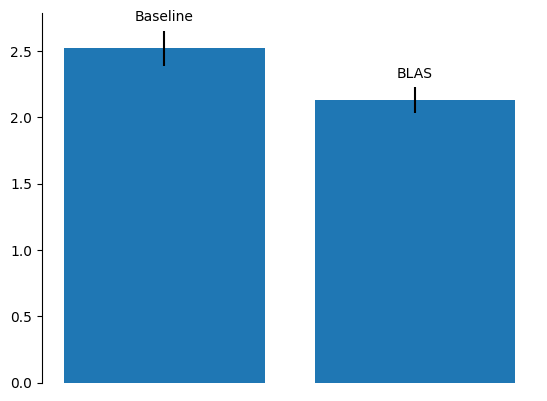

In [290]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
b = ax.bar([1,2], [2.52, 2.13], yerr=[134e-3, 94.5e-3], width=0.8)
ax.bar_label(b, labels=['Baseline', 'BLAS'], padding=5)
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.get_xaxis().set_visible(False)